# Disaster Prediction via tweets

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">navigation</h3>

* [1. Library](#1)
* [2. Data reading](#2)
* [3. Data preprocessing and visulization](#3)
* [4. Text cleaning](#4)
* [5. Simple sentiment analysis and Create wordcloud](#5)
* [6. vectorization](#6)
* [7. Model fitting and Predication, Get clasification report](#7)
* [8. Test Model on test file adn sumitted in sumbision file](#8)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


<a id="1"></a>

# Library

In [2]:
import plotly 
import matplotlib.pyplot as plt
import re 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib
from nltk.tokenize import RegexpTokenizer
import nltk
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix 
from imblearn.combine import SMOTETomek
from wordcloud import WordCloud
import plotly.graph_objects as go

nltk.download('stopwords')


stop_words = set(stopwords.words("english"))
default_stemmer = PorterStemmer()
default_stopwords = stopwords.words('english')
default_tokenizer=RegexpTokenizer(r"\w+")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id="2"></a>

# Data reading

In [3]:
df = pd.read_csv("../input/nlp-getting-started/train.csv") 
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.shape

(7613, 5)

In [5]:
df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [6]:
df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

<a id="3"></a>

# Data preprocessing and visulization

In [7]:
df_target = df["target"].value_counts()
fig = go.Figure([go.Pie(labels=df_target.index, values=df_target.values
                        ,hole=0.5)])  # can change the size of hole 

fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=15)
fig.update_layout(title="Disaster Tweets target columns distribution",title_x=0.5)
fig.show()

In [8]:
df_columns = df.columns.tolist()
null_value_counts = df[df_columns].isnull().sum()

fig = go.Figure(go.Bar(
    x=null_value_counts.index,y=null_value_counts.values,text=null_value_counts.values,
    textposition = "outside",
))
fig.update_layout(title_text='Null value counts',xaxis_title="Column name",yaxis_title="Counts of null values")
fig.show()

In [9]:
df['keyword'] = df['keyword'].astype(str)
df['text'] = df[['keyword', 'text']].apply(lambda x: ' '.join(x), axis = 1) 

In [10]:
df = df.drop(["location","keyword"],axis = 1)

<a id="4"></a>

# Text cleaning

In [11]:
def clean_text(text, ):
        if text is not None:
        #exclusions = ['RE:', 'Re:', 're:']
        #exclusions = '|'.join(exclusions)
                text = re.sub(r'[0-9]+','',text)
                text =  text.lower()
                text = re.sub('re:', '', text)
                text = re.sub('-', '', text)
                text = re.sub('_', '', text)
                text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
                text = re.sub(r'\S*@\S*\s?', '', text, flags=re.MULTILINE)
        # Remove text between square brackets
                text =re.sub('\[[^]]*\]', '', text)
        # removes punctuation
                text = re.sub(r'[^\w\s]','',text)
                text = re.sub(r'\n',' ',text)
                text = re.sub(r'[0-9]+','',text)
                #text = re.sub(r'[0-9]+','',text)
        # strip html 
                p = re.compile(r'<.*?>')
                text = re.sub(r"\'ve", " have ", text)
                text = re.sub(r"can't", "cannot ", text)
                text = re.sub(r"n't", " not ", text)
                text = re.sub(r"I'm", "I am", text)
                text = re.sub(r" m ", " am ", text)
                text = re.sub(r"\'re", " are ", text)
                text = re.sub(r"\'d", " would ", text)
                text = re.sub(r"\'ll", " will ", text)
        
                text = p.sub('', text)

        def tokenize_text(text,tokenizer=default_tokenizer):
            token = default_tokenizer.tokenize(text)
            return token
        
        def remove_stopwords(text, stop_words=default_stopwords):
            tokens = [w for w in tokenize_text(text) if w not in stop_words]
            return ' '.join(tokens)

        def stem_text(text, stemmer=default_stemmer):
            tokens = tokenize_text(text)
            return ' '.join([stemmer.stem(t) for t in tokens])

        text = stem_text(text) # stemming
        text = remove_stopwords(text) # remove stopwords
        #text.strip(' ') # strip whitespaces again?

        return text

In [12]:
df['text'] = df['text'].apply(clean_text)


<a id="5"></a>

# Simple sentiment analysis and Create wordcloud

In [13]:
tweet_text_list = df.text.tolist()
tweet_text_string = ''.join(tweet_text_list)

In [14]:
high_freq_word = pd.Series(' '.join(df['text']).split()).value_counts()[:20]

In [15]:
fig = go.Figure(go.Bar(y=high_freq_word.index, x=high_freq_word.values,orientation="h",marker={'color': high_freq_word.values,'colorscale': 'Viridis'} ))
fig.update_layout(title_text='Search most frequent word use in text column',xaxis_title="Count",yaxis_title="Words")
fig.show()

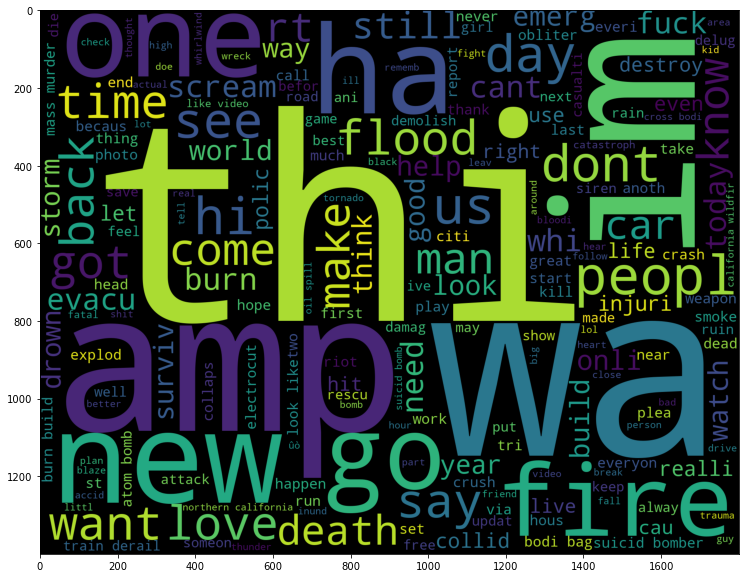

In [16]:
wordcloud_ip = WordCloud(
                      background_color='black',
                      margin=3,
                      width=1800,
                      height=1400,
                      max_words=200
                     ).generate(tweet_text_string)

plt.figure( figsize=(20,10) )
plt.imshow(wordcloud_ip)

<a id="6"></a>

# Vectorization

In [17]:
cv = TfidfVectorizer(max_features = 1000)
x = cv.fit_transform(df['text'])
df1 = pd.DataFrame(x.toarray(), columns=cv.get_feature_names())
df.drop(["text"], axis=1, inplace=True)
main_df = pd.concat([df,df1], axis=1)

In [18]:
main_df.head()

,id,target,abc,ablaz,absolut,accid,account,across,act,action,...,yearold,yet,york,young,youth,youtub,yr,zone,ûò,ûó
0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id="7"></a>

# Model fitting and Predication, Get clasification report

In [19]:
Y = main_df.iloc[:,1]
X = main_df.iloc[:,2:]

In [20]:
rfc = RandomForestClassifier(n_jobs=3,oob_score=True,n_estimators=2000,criterion="entropy")
model=rfc.fit(X,Y)

In [21]:
rfc.score(X,Y)

0.9753053986601865

In [22]:
rfc_predict = rfc.predict(X)

In [23]:
print(classification_report(Y, rfc_predict))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4342
           1       0.98      0.96      0.97      3271

    accuracy                           0.98      7613
   macro avg       0.98      0.97      0.97      7613
weighted avg       0.98      0.98      0.98      7613



In [24]:
confusion_matrix(Y, rfc_predict)

array([[4284,   58],
       [ 130, 3141]])

<a id="8"></a>

# Test Model on test file and sumitted in sumbision file

In [25]:
test = pd.read_csv("../input/nlp-getting-started/test.csv",usecols=["text","id"])
test.shape

(3263, 2)

In [26]:
test['text'] = test['text'].apply(clean_text)
vect = cv.transform(test['text']).toarray()
test["target"] = rfc.predict(vect)

In [27]:
submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv",usecols=["id"])
submission

,id
0,0
1,2
2,3
3,9
4,11
...,...
3258,10861
3259,10865
3260,10868
3261,10874


In [28]:
submission = submission.set_index('id').join(test.set_index('id'))
submission = submission.drop(["text"],axis=1)

In [29]:
submission["target"].value_counts()

0    2072
1    1191
Name: target, dtype: int64

In [30]:
submission.to_csv("submission.csv")